# Phase Retrieval in ∂Lux

In this notebook, we will go through a simple example of phase retrieval in ∂Lux: recovering Zernike coefficients for an aberrated circular aperture by gradient descent. As noted by [Martinache et al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..422M/abstract), you can only detect the sign of even-order aberrations if your pupil is not inversion-symmetric.

We will follow the example in the paper and recover Zernike aberrations using a circular pupil with an additional bar asymmetry.

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.layers as dll
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

We want to construct a basic optical system with a $2.4\, \text{m}$ aperture, along with some Zernike aberrations and a bar mask.

We also create a simple `PointSource` object that we want to model.

Let's see how we can do this in ∂Lux.

In [4]:
# Wavefront properties
diameter = 2.4
wf_npixels = 256

# Construct an aperture with a single spider as the asymmetry
oversample = 5
coords = dlu.pixel_coords(oversample*wf_npixels, diameter)
circle = dlu.circle(coords, diameter/2)
spider = dlu.spider(coords, diameter/6, [90])
transmission = dlu.combine([circle, spider], oversample)

# Zernike aberrations
zernike_indexes = np.arange(4, 11)
coeffs = 1e-7*jr.normal(jr.PRNGKey(0), zernike_indexes.shape)
coords = dlu.pixel_coords(wf_npixels, diameter)
basis = dlu.zernike_basis(zernike_indexes, coords, diameter)

layers = [
    ('aperture', dll.BasisOptic(transmission, basis, coeffs, normalise=True))
]

# psf params
psf_npixels = 256 
psf_pixel_scale = 1e-2 # arcseconds

# Construct Optics
optics = dl.AngularOptics(wf_npixels, diameter, layers, psf_npixels, psf_pixel_scale)

# Create a point source
source = dl.PointSource(flux=1e5, wavelengths=np.linspace(1e-6, 1.5e-6, 5))

Let's examine the resulting optical system and generate some data.

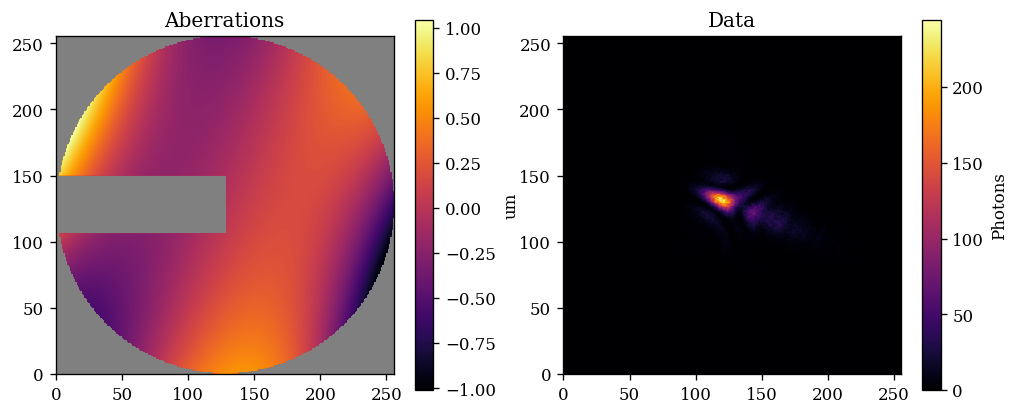

In [5]:
# Model the psf and add some photon noise
psf = optics.model(source)
data = jr.poisson(jr.PRNGKey(1), psf)

# Get mask, setting nan values for visualisation
support = optics.aperture.transmission
support_mask = support.at[support < .5].set(np.nan)

# Get aberrations
opd = optics.aperture.eval_basis()

# Plot
cmap = colormaps['inferno']
cmap.set_bad('k',.5)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(support_mask * opd * 1e6, cmap=cmap)
plt.title("Aberrations")
plt.colorbar(label='um')

plt.subplot(1, 2, 2)
plt.title("Data")
plt.imshow(data)
plt.colorbar(label='Photons')
plt.show()

Excellent! Now we want to try and recover these aberrations. To do this, we create a new optical system with a *different* set of Zernike aberrations. If we define the path to the optical aberration coefficients, we can use the `.set()` method to assign newly randomised coefficient values. With this new optical system we will try to recover the original aberration coefficients using gradient descent methods.

In [6]:
# Define path to the zernikes
param = 'aperture.coefficients'
coeffs_init = 1e-7*jr.normal(jr.PRNGKey(2), (len(coeffs),))
model = optics.multiply(param, 0)

Now we need to define our loss function, and specify that we want to optimise the Zernike coefficients. To do this, we pass the string path to the Zernike coefficients into the `zdx.filter_value_and_grad()` function. Note that we also use the `zdx.filter_jit()` function in order to compile this function into XLA so that future evaluations will be much faster!

In [7]:
# Define loss function
@zdx.filter_jit
@zdx.filter_value_and_grad(param)
def loss_func(model, source, data):
    psf = model.model(source)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, psf))

Compiling the function into XLA:

In [8]:
%%time
loss, initial_grads = loss_func(model, source, data) # Compile
print("Initial Loss: {}".format(loss))

Initial Loss: 157710.6875
CPU times: user 265 ms, sys: 13.6 ms, total: 278 ms
Wall time: 215 ms


Now, we begin the optimisation loop using `optax` with a low learning rate.

In [9]:
optim, opt_state = zdx.get_optimiser(model, param, optax.adam(1e-8))

losses, models_out = [], []
with tqdm(range(100), desc='Gradient Descent') as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = loss_func(model, source, data) 
        
        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        
        # save results
        models_out.append(model) 
        losses.append(loss)
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Now, we visualise this: we have great performance, recovering the input Zernike coefficients and PSF accurately.

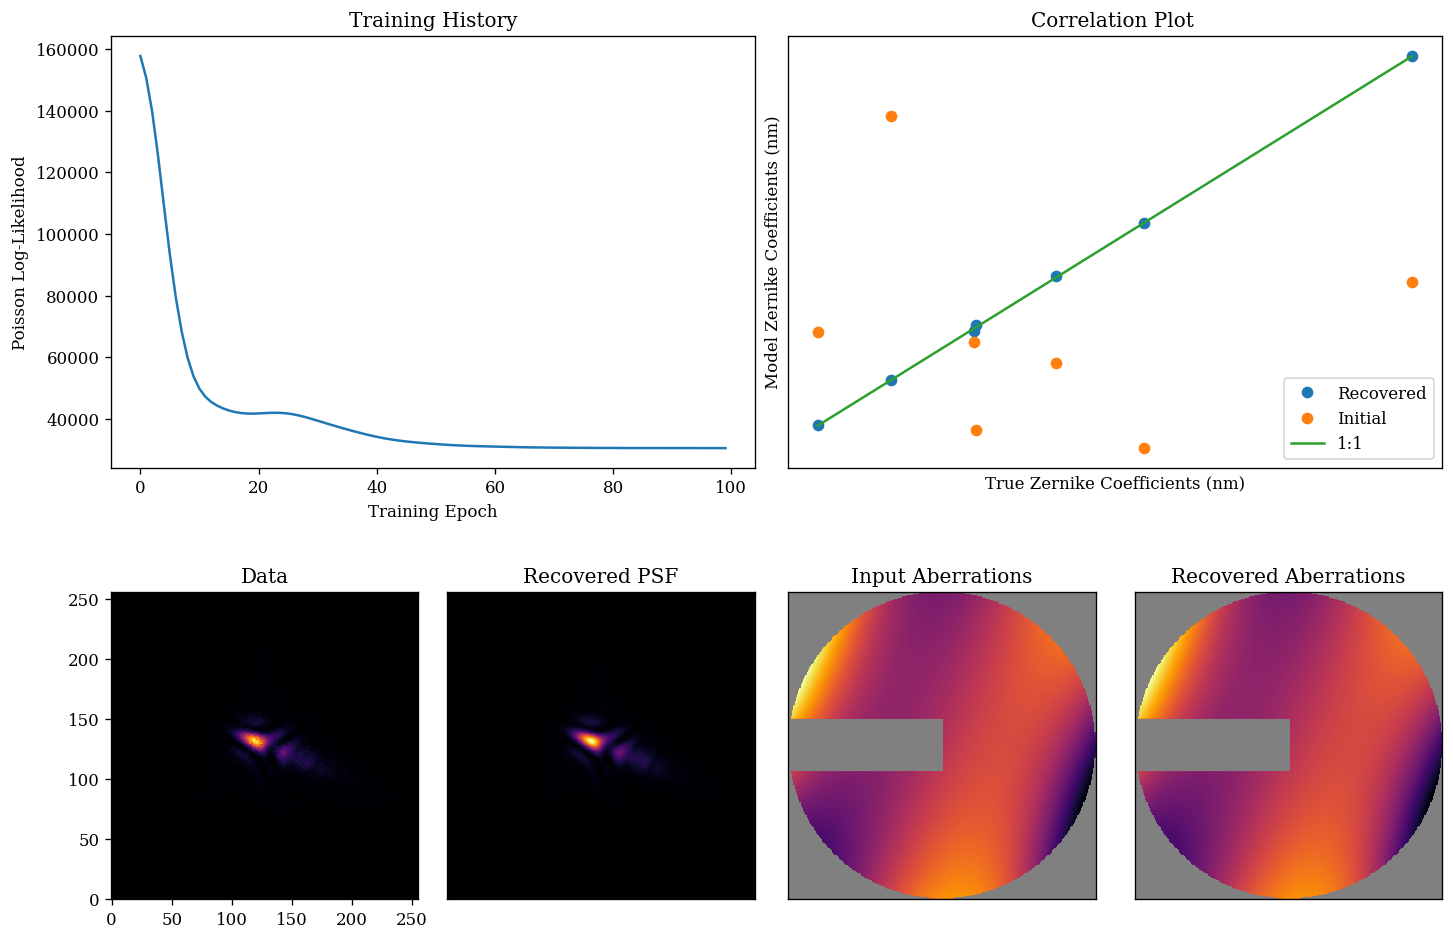

In [10]:
psf = model.model(source)
coeffs_found = np.array([model_out.get(param) for model_out in models_out])

mosaic = """
    AABB
    CDEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['B','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(losses))
axes['A'].set_title("Training History")
axes['A'].set_xlabel('Training Epoch')
axes['A'].set_ylabel('Poisson Log-Likelihood')

axes['B'].plot(coeffs*1e9, coeffs_found[-1]*1e9,'.', markersize=12,color='C0',label='Recovered')
axes['B'].plot(coeffs*1e9, coeffs_init*1e9,'.', markersize=12,color='C1',label='Initial')

axes['B'].plot(np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               '-',color='C2',label='1:1')
axes['B'].legend()
axes['B'].set_title('Correlation Plot ')
axes['B'].set_xlabel('True Zernike Coefficients (nm)')
axes['B'].set_ylabel('Model Zernike Coefficients (nm)')

axes['C'].imshow(data)
axes['C'].set_title('Data')

axes['D'].imshow(psf)
axes['D'].set_title('Recovered PSF')

axes['E'].imshow(support_mask*opd, cmap=cmap)
axes['E'].set_title('Input Aberrations')

axes['F'].imshow(support_mask*model.aperture.eval_basis(), cmap=cmap)
axes['F'].set_title('Recovered Aberrations')
plt.show()